In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet50
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 42
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

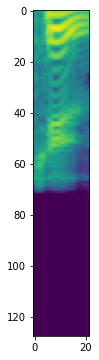

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
1.2198216556924995
TEST
loss: 0.9483989725830735
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.49039058590294793
TEST
loss: 0.5634501307241379
accuracy: 0.8344086021505376
******************
epoch: 2
Train
0.3999203706082954
TEST
loss: 0.35410948761047856
accuracy: 0.8774193548387097
******************
epoch: 3
Train
0.22370968878622266
TEST
loss: 0.3502458639042352
accuracy: 0.9118279569892473
******************
epoch: 4
Train
0.32938811338647567
TEST
loss: 0.5645979358303932
accuracy: 0.843010752688172
******************
epoch: 5
Train
0.28963307141615746
TEST
loss: 0.35424169189827415
accuracy: 0.9032258064516129
******************
epoch: 6
Train
0.20683690505959876
TEST
loss: 0.2904773364143987
accuracy: 0.9204301075268817
******************
epoch: 7
Train
0.26669931589883056
TEST
loss: 0.31272403136376414
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.23831454274085626
TEST
loss: 0.4131986902606103
accuracy: 0.886021505376344
***

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


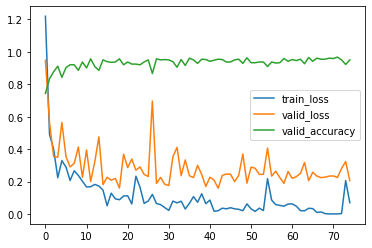

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1321767248257424
TEST
loss: 1.0992690809311405
accuracy: 0.6989247311827957
******************
epoch: 1
Train
0.528743400391418
TEST
loss: 0.8215399310153018
accuracy: 0.7935483870967742
******************
epoch: 2
Train
0.35227842547910215
TEST
loss: 1.0243422750503786
accuracy: 0.7376344086021506
******************
epoch: 3
Train
0.38091646578598226
TEST
loss: 0.47092953465318166
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.25213393098767495
TEST
loss: 0.4316698572968924
accuracy: 0.9118279569892473
******************
epoch: 5
Train
0.30473686728223265
TEST
loss: 0.5541991654262748
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.24848511534219925
TEST
loss: 0.5798473412952115
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.2620520613882962
TEST
loss: 0.459404710736326
accuracy: 0.8795698924731182
******************
epoch: 8
Train
0.2581799642559528
TEST
loss: 0.6145958767142347
accurac

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


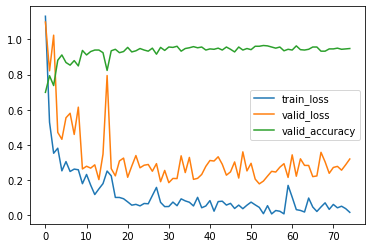

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.361844208783595
TEST
loss: 1.1957070040446456
accuracy: 0.6709677419354839
******************
epoch: 1
Train
0.6019739493543125
TEST
loss: 0.5118713394288094
accuracy: 0.8516129032258064
******************
epoch: 2
Train
0.4580078546116284
TEST
loss: 0.9406428447333716
accuracy: 0.7548387096774194
******************
epoch: 3
Train
0.48784448475239417
TEST
loss: 0.674356311239222
accuracy: 0.8021505376344086
******************
epoch: 4
Train
0.3487918398748756
TEST
loss: 0.2825778927854312
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.3125280668546772
TEST
loss: 0.6909252237248165
accuracy: 0.810752688172043
******************
epoch: 6
Train
0.33055283667647073
TEST
loss: 0.49974176101787116
accuracy: 0.8473118279569892
******************
epoch: 7
Train
0.25389097496971497
TEST
loss: 0.2873195679918412
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.2542459243847339
TEST
loss: 0.2695785218669522
accuracy:

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


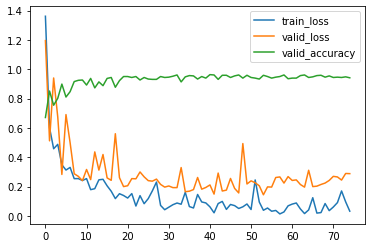

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1881404487946756
TEST
loss: 0.5173468428273355
accuracy: 0.8236559139784946
******************
epoch: 1
Train
0.5086040292687486
TEST
loss: 0.2841487188493052
accuracy: 0.9032258064516129
******************
epoch: 2
Train
0.372888906257539
TEST
loss: 0.6689036428287465
accuracy: 0.7935483870967742
******************
epoch: 3
Train
0.3662307344108226
TEST
loss: 0.608212090724258
accuracy: 0.8559139784946237
******************
epoch: 4
Train
0.24492633455083393
TEST
loss: 0.2534754112202634
accuracy: 0.9376344086021505
******************
epoch: 5
Train
0.2337550227848766
TEST
loss: 0.43469858259283084
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.2512294823724092
TEST
loss: 0.786170873847059
accuracy: 0.7827956989247312
******************
epoch: 7
Train
0.17968553818228686
TEST
loss: 0.2065234936052753
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.22638170996467208
TEST
loss: 0.6976401235467644
accuracy:

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


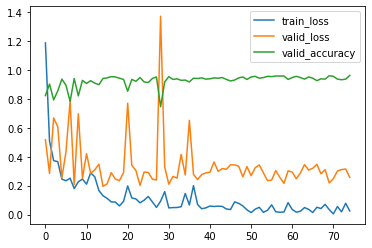

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1964045700747028
TEST
loss: 1.4758991187618624
accuracy: 0.6795698924731183
******************
epoch: 1
Train
0.5053372381833785
TEST
loss: 1.1852443387431484
accuracy: 0.7440860215053764
******************
epoch: 2
Train
0.41250447804528534
TEST
loss: 1.0739223732743213
accuracy: 0.7806451612903226
******************
epoch: 3
Train
0.3793228537277567
TEST
loss: 0.9911516838176276
accuracy: 0.7763440860215054
******************
epoch: 4
Train
0.31828985178284447
TEST
loss: 0.47608671271672814
accuracy: 0.8774193548387097
******************
epoch: 5
Train
0.247365992109045
TEST
loss: 0.3079772340354099
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.30096030562682763
TEST
loss: 0.6447630359280494
accuracy: 0.8279569892473119
******************
epoch: 7
Train
0.22830975126308592
TEST
loss: 0.2843367414448851
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.23214455179200097
TEST
loss: 0.3070863979157581
accur

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


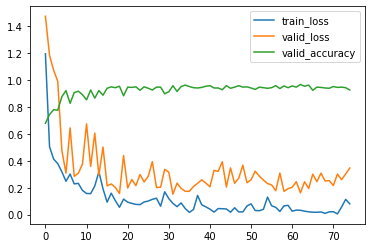

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1025288185896127
TEST
loss: 1.6155814219546574
accuracy: 0.7634408602150538
******************
epoch: 1
Train
0.5467190940211907
TEST
loss: 0.5976588706175486
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.39063878321300993
TEST
loss: 0.5146641352484304
accuracy: 0.8473118279569892
******************
epoch: 3
Train
0.3488672867088338
TEST
loss: 0.5627296224717171
accuracy: 0.8279569892473119
******************
epoch: 4
Train
0.3245090363034652
TEST
loss: 0.6599883774275421
accuracy: 0.8193548387096774
******************
epoch: 5
Train
0.375467465780214
TEST
loss: 0.375914736781069
accuracy: 0.8838709677419355
******************
epoch: 6
Train
0.30174013453911375
TEST
loss: 0.30891766506497575
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.23653604057314065
TEST
loss: 0.34295428619589857
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.261638650328611
TEST
loss: 0.4041219631510396
accuracy

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


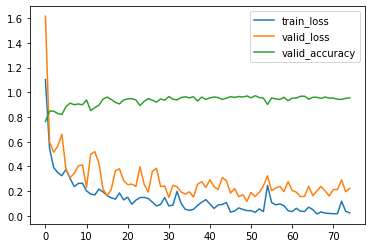

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
2.0092864458960236
TEST
loss: 2.0019098748442947
accuracy: 0.5053763440860215
******************
epoch: 1
Train
1.5459755225790144
TEST
loss: 1.1690411465142363
accuracy: 0.6494623655913978
******************
epoch: 2
Train
1.3913016246093108
TEST
loss: 0.9237788352915036
accuracy: 0.6903225806451613
******************
epoch: 3
Train
1.2012646647634593
TEST
loss: 0.5637248347523391
accuracy: 0.8086021505376344
******************
epoch: 4
Train
1.1053739924166366
TEST
loss: 0.7441358869434684
accuracy: 0.7290322580645161
******************
epoch: 5
Train
1.1302334757729378
TEST
loss: 0.7648472300139807
accuracy: 0.7720430107526882
******************
epoch: 6
Train
1.0444639785737841
TEST
loss: 0.7561396580870433
accuracy: 0.8
******************
epoch: 7
Train
1.0896312593450839
TEST
loss: 0.6801147626292321
accuracy: 0.810752688172043
******************
epoch: 8
Train
0.9730158797116708
TEST
loss: 0.40189879825038294
accuracy: 0.8645161290322

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


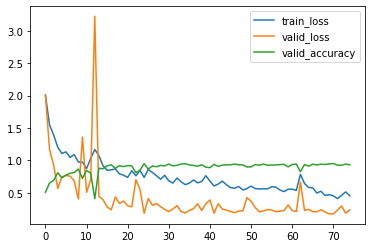

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.710444494544272
TEST
loss: 9.981712406937794
accuracy: 0.09462365591397849
******************
epoch: 1
Train
0.8185482584923008
TEST
loss: 1.0454276205391013
accuracy: 0.6494623655913978
******************
epoch: 2
Train
0.6256539101361843
TEST
loss: 0.9674081774168117
accuracy: 0.6688172043010753
******************
epoch: 3
Train
0.47243021750360265
TEST
loss: 1.637599782020815
accuracy: 0.44731182795698926
******************
epoch: 4
Train
0.3727818814155936
TEST
loss: 1.301651938243579
accuracy: 0.5698924731182796
******************
epoch: 5
Train
0.5119514304845643
TEST
loss: 1.571069089827999
accuracy: 0.6258064516129033
******************
epoch: 6
Train
0.3938167385343717
TEST
loss: 2.5050429544141215
accuracy: 0.4774193548387097
******************
epoch: 7
Train
0.38484469596968585
TEST
loss: 0.5111547240646936
accuracy: 0.8580645161290322
******************
epoch: 8
Train
0.4096278296918977
TEST
loss: 0.45836097309666296
accuracy: 

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9104991394148021


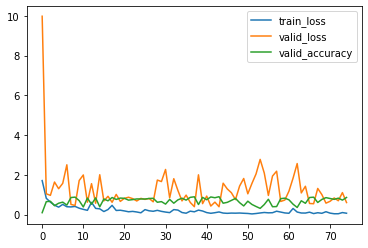

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1363370889736621
TEST
loss: 1.5109846447744677
accuracy: 0.7247311827956989
******************
epoch: 1
Train
0.45606741086089875
TEST
loss: 0.789354573270326
accuracy: 0.8129032258064516
******************
epoch: 2
Train
0.36533880683126535
TEST
loss: 0.32568723021015045
accuracy: 0.8881720430107527
******************
epoch: 3
Train
0.2797479523756071
TEST
loss: 0.44821892207668673
accuracy: 0.8666666666666667
******************
epoch: 4
Train
0.3150363164880164
TEST
loss: 0.2735998922137804
accuracy: 0.9204301075268817
******************
epoch: 5
Train
0.216298655662475
TEST
loss: 0.24041961348184976
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.26213524902643665
TEST
loss: 0.31056018721672796
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.35081661049242485
TEST
loss: 0.9139071090247042
accuracy: 0.7741935483870968
******************
epoch: 8
Train
0.3447515087610429
TEST
loss: 0.1915467357443225
accu

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9707401032702238


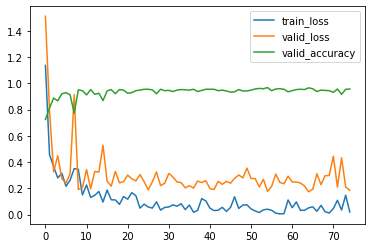

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0803536097722215
TEST
loss: 1.3986578833672307
accuracy: 0.7548387096774194
******************
epoch: 1
Train
0.5425016308703856
TEST
loss: 0.41625556125435775
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.3672573821931098
TEST
loss: 0.5151887600139905
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.3149471171260458
TEST
loss: 0.3108156924286196
accuracy: 0.9182795698924732
******************
epoch: 4
Train
0.3368007885588069
TEST
loss: 0.3821733153635456
accuracy: 0.8838709677419355
******************
epoch: 5
Train
0.2925012742375326
TEST
loss: 0.655188141458778
accuracy: 0.8516129032258064
******************
epoch: 6
Train
0.27820558026713843
TEST
loss: 0.40565661435486167
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.23202191724145546
TEST
loss: 0.3528284723079333
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.19590355942951587
TEST
loss: 0.2859696395935551
accura

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


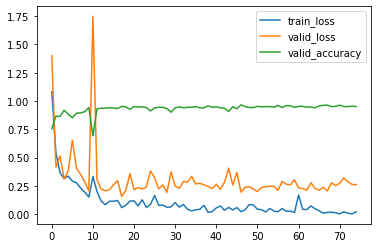

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1641500116871066
TEST
loss: 1.0051513043783045
accuracy: 0.7741935483870968
******************
epoch: 1
Train
0.5642225407244508
TEST
loss: 0.465865877110471
accuracy: 0.875268817204301
******************
epoch: 2
Train
0.4877641443674707
TEST
loss: 0.7766987327606447
accuracy: 0.7784946236559139
******************
epoch: 3
Train
0.4104890402247974
TEST
loss: 0.8410544590283465
accuracy: 0.7161290322580646
******************
epoch: 4
Train
0.4401690795592358
TEST
loss: 0.9527267409909156
accuracy: 0.7763440860215054
******************
epoch: 5
Train
0.31587575954587216
TEST
loss: 0.27564456828178896
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.254790532184533
TEST
loss: 0.2485960288073427
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.1967561388439431
TEST
loss: 0.20208463811425753
accuracy: 0.9440860215053763
******************
epoch: 8
Train
0.2850673447132881
TEST
loss: 1.1696282381652503
accuracy: 

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


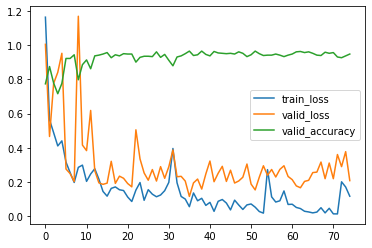

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
2.0562594767597715
TEST
loss: 2.7379000509938884
accuracy: 0.421505376344086
******************
epoch: 1
Train
1.6676311527584982
TEST
loss: 1.6082592894954066
accuracy: 0.4752688172043011
******************
epoch: 2
Train
1.602760052128896
TEST
loss: 1.0106856981913248
accuracy: 0.7032258064516129
******************
epoch: 3
Train
1.4358537808245206
TEST
loss: 0.8776084510228968
accuracy: 0.7053763440860215
******************
epoch: 4
Train
1.2615452300622763
TEST
loss: 0.7143375583874282
accuracy: 0.810752688172043
******************
epoch: 5
Train
1.1915406279494574
TEST
loss: 0.5664383426789315
accuracy: 0.821505376344086
******************
epoch: 6
Train
1.0630680374644685
TEST
loss: 0.4269032375786894
accuracy: 0.8580645161290322
******************
epoch: 7
Train
1.1318275586982278
TEST
loss: 0.6558141424450823
accuracy: 0.8021505376344086
******************
epoch: 8
Train
1.0458683911099123
TEST
loss: 0.5435778170503596
accuracy: 0.84

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


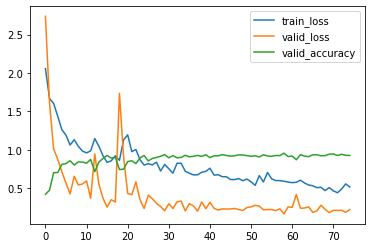

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.1508822175335613
TEST
loss: 1.005449463346953
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.5292892335368923
TEST
loss: 0.46890954977722576
accuracy: 0.853763440860215
******************
epoch: 2
Train
0.4023149968734273
TEST
loss: 0.4422744752258383
accuracy: 0.8580645161290322
******************
epoch: 3
Train
0.41210105654111007
TEST
loss: 0.7056626314757972
accuracy: 0.8559139784946237
******************
epoch: 4
Train
0.34005059769671003
TEST
loss: 0.37230304902599703
accuracy: 0.8881720430107527
******************
epoch: 5
Train
0.2906083792977649
TEST
loss: 0.4243334923380165
accuracy: 0.8774193548387097
******************
epoch: 6
Train
0.31784880199802135
TEST
loss: 0.3076601451443088
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.256554185798493
TEST
loss: 0.22196214218293467
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.28339474420747773
TEST
loss: 0.3791513940339447
accura

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


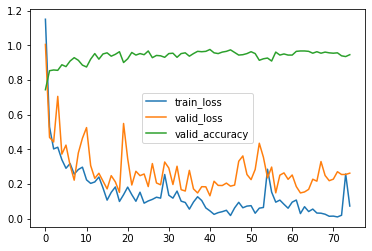

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
2.0227563420995693
TEST
loss: 2.3063618552300236
accuracy: 0.4752688172043011
******************
epoch: 1
Train
1.5069507700689517
TEST
loss: 1.0971696212727537
accuracy: 0.6860215053763441
******************
epoch: 2
Train
1.331277328854809
TEST
loss: 0.8456023628993701
accuracy: 0.7247311827956989
******************
epoch: 3
Train
1.236527291112005
TEST
loss: 0.5098628382528981
accuracy: 0.8451612903225807
******************
epoch: 4
Train
1.0657782979594421
TEST
loss: 0.5028424577046466
accuracy: 0.821505376344086
******************
epoch: 5
Train
1.0407080441055339
TEST
loss: 0.4545421099790963
accuracy: 0.864516129032258
******************
epoch: 6
Train
0.9673195669711374
TEST
loss: 0.5766925669485523
accuracy: 0.8473118279569892
******************
epoch: 7
Train
0.9639417861954911
TEST
loss: 0.80646592673435
accuracy: 0.7677419354838709
******************
epoch: 8
Train
1.054500165393934
TEST
loss: 0.8540157894934377
accuracy: 0.75483

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


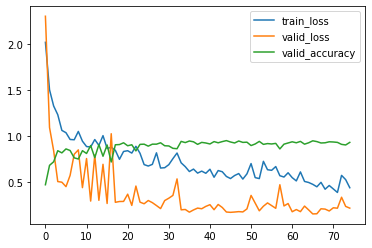

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.195418044066134
TEST
loss: 1.1981990442481092
accuracy: 0.7118279569892473
******************
epoch: 1
Train
0.4979349312502399
TEST
loss: 0.5115083515003164
accuracy: 0.843010752688172
******************
epoch: 2
Train
0.3958274594031166
TEST
loss: 0.26432977735355334
accuracy: 0.9118279569892473
******************
epoch: 3
Train
0.26443731829756745
TEST
loss: 0.7177875129125452
accuracy: 0.8494623655913979
******************
epoch: 4
Train
0.3424686137937896
TEST
loss: 0.6297594375507806
accuracy: 0.8623655913978494
******************
epoch: 5
Train
0.2561349607502573
TEST
loss: 0.4411977501646165
accuracy: 0.8881720430107527
******************
epoch: 6
Train
0.2429487581014248
TEST
loss: 0.42968441975373095
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.2553965108781074
TEST
loss: 0.38174885075579407
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.18639761105171762
TEST
loss: 0.327888270026894
accuracy:

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9690189328743546


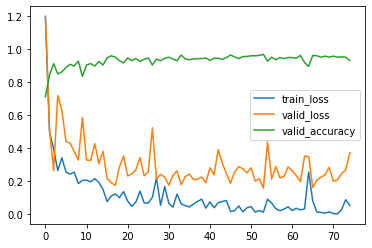

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.2978298456102657
TEST
loss: 1.4815716110250001
accuracy: 0.6258064516129033
******************
epoch: 1
Train
0.5936752736857327
TEST
loss: 0.8823851053432752
accuracy: 0.7763440860215054
******************
epoch: 2
Train
0.522321245525239
TEST
loss: 0.41246408659924744
accuracy: 0.875268817204301
******************
epoch: 3
Train
0.35621236098602244
TEST
loss: 1.2476824775818856
accuracy: 0.7462365591397849
******************
epoch: 4
Train
0.36044231665410464
TEST
loss: 0.2907636514274023
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.28463058222604815
TEST
loss: 0.5166654568846508
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.3549825721488053
TEST
loss: 0.5572900026075301
accuracy: 0.8279569892473119
******************
epoch: 7
Train
0.30839303301172866
TEST
loss: 0.3929844003851696
accuracy: 0.8774193548387097
******************
epoch: 8
Train
0.27189069610805233
TEST
loss: 0.33289933602015176
accur

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


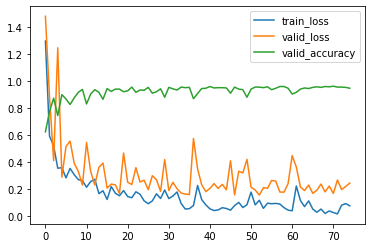

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.134955225802264
TEST
loss: 0.6837840108461277
accuracy: 0.7784946236559139
******************
epoch: 1
Train
0.45099632728465733
TEST
loss: 0.6220801727746123
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.40696468620320836
TEST
loss: 0.4186106491473413
accuracy: 0.8946236559139785
******************
epoch: 3
Train
0.34823943012558006
TEST
loss: 1.1166469458610782
accuracy: 0.7548387096774194
******************
epoch: 4
Train
0.304953149010818
TEST
loss: 0.3333582157729774
accuracy: 0.9096774193548387
******************
epoch: 5
Train
0.23550274934445137
TEST
loss: 0.30045453736218075
accuracy: 0.9053763440860215
******************
epoch: 6
Train
0.2515810170222433
TEST
loss: 0.3839791620610863
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.2561036610256682
TEST
loss: 0.22793083742100706
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.2846225091428223
TEST
loss: 0.3188642390953597
accurac

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


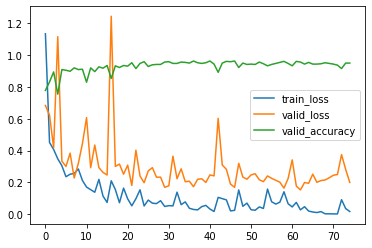

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.3513940765964259
TEST
loss: 1.2440268911341186
accuracy: 0.6838709677419355
******************
epoch: 1
Train
0.5523704861079612
TEST
loss: 0.6469912704601083
accuracy: 0.8172043010752689
******************
epoch: 2
Train
0.4808969624785884
TEST
loss: 0.5133475241481616
accuracy: 0.8602150537634409
******************
epoch: 3
Train
0.35890254026853596
TEST
loss: 0.7420564632261953
accuracy: 0.810752688172043
******************
epoch: 4
Train
0.37190709668715666
TEST
loss: 0.5760493737395092
accuracy: 0.8172043010752689
******************
epoch: 5
Train
0.3107448969724426
TEST
loss: 0.6029257961338567
accuracy: 0.8408602150537634
******************
epoch: 6
Train
0.2881110021358032
TEST
loss: 0.38205542013209354
accuracy: 0.8795698924731182
******************
epoch: 7
Train
0.27240099775964494
TEST
loss: 0.2774851701913341
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.35672449012822083
TEST
loss: 0.27451244304257055
accur

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


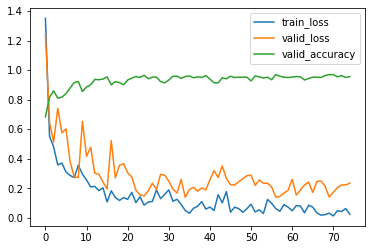

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.2803362812736565
TEST
loss: 0.9611685641350285
accuracy: 0.7333333333333333
******************
epoch: 1
Train
0.4980766814308393
TEST
loss: 0.6218987654614192
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.45322845222234853
TEST
loss: 0.47391790863006344
accuracy: 0.8494623655913979
******************
epoch: 3
Train
0.3056069577196046
TEST
loss: 0.6929175276910106
accuracy: 0.7720430107526882
******************
epoch: 4
Train
0.34230403368615564
TEST
loss: 0.5459353236741917
accuracy: 0.8774193548387097
******************
epoch: 5
Train
0.2723207867267508
TEST
loss: 0.3063826759496043
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.24577007259357084
TEST
loss: 0.44648372261754926
accuracy: 0.864516129032258
******************
epoch: 7
Train
0.23784264432658545
TEST
loss: 0.3128583252750417
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.27627411081897485
TEST
loss: 0.30825291705387897
acc

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9690189328743546


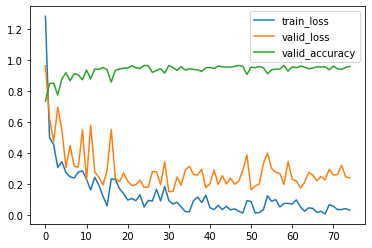

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.5995483281603409
TEST
loss: 1.3609155916398572
accuracy: 0.6688172043010753
******************
epoch: 1
Train
0.7809179534049334
TEST
loss: 0.7114571154117584
accuracy: 0.7935483870967742
******************
epoch: 2
Train
0.6093631912831279
TEST
loss: 0.34217275887407284
accuracy: 0.8881720430107527
******************
epoch: 3
Train
0.465487585185867
TEST
loss: 0.595952453536372
accuracy: 0.8086021505376344
******************
epoch: 4
Train
0.411771421221937
TEST
loss: 0.4481037490470435
accuracy: 0.8494623655913979
******************
epoch: 5
Train
0.47754688101169174
TEST
loss: 0.36979968669593977
accuracy: 0.9032258064516129
******************
epoch: 6
Train
0.39268397758516754
TEST
loss: 0.4223236169225426
accuracy: 0.8731182795698925
******************
epoch: 7
Train
0.4127654266665556
TEST
loss: 0.3454997729229671
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.46616855088779857
TEST
loss: 0.6829730326129544
accuracy

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


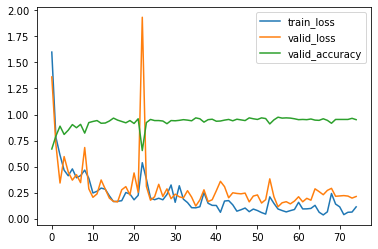

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()